# Rasio 1 banding 1

### Import Library

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import random as rn
import matplotlib.pyplot as plt
import time

### Pra pemrosesan
from sklearn.preprocessing import MinMaxScaler

### Near Miss under sampling
from imblearn.under_sampling import NearMiss 

### Smote over sampling
from imblearn.over_sampling import SMOTE

### Kmeans sampling
from sklearn.cluster import MiniBatchKMeans

### Bagi data
from sklearn.model_selection import train_test_split

### Seleksi fitur chi-square
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### Long short term memory (LSTM)
from tensorflow.keras.models import Sequential
from tensorflow import keras
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, SpatialDropout1D, Flatten, Reshape
from keras.layers import Bidirectional, CuDNNLSTM

### Random forest
from sklearn.ensemble import RandomForestClassifier

### metrik pengukuran
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

### save model
import joblib

import warnings
warnings.filterwarnings('ignore')

# menampilkan lebih banyak kolom dan baris pada Dataset
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# Tipe Dataset #
# ============ #

tipe_df = {'dst_port':'uint32','protocol':'uint8','timestamp':'uint64','flow_duration':'int64','tot_fwd_pkts':'uint32','tot_bwd_pkts':'uint32','totlen_fwd_pkts':'uint32','totlen_bwd_pkts':'uint32','fwd_pkt_len_max':'uint16','fwd_pkt_len_min':'uint16',
'fwd_pkt_len_mean':'float32','fwd_pkt_len_std':'float32','bwd_pkt_len_max':'uint16','bwd_pkt_len_min':'uint16','bwd_pkt_len_mean':'float32','bwd_pkt_len_std':'float32','flow_byts_s':'float64','flow_pkts_s':'float64','flow_iat_mean':'float32','flow_iat_std':'float32',
'flow_iat_max':'int64','flow_iat_min':'int64','fwd_iat_tot':'int64','fwd_iat_mean':'float32','fwd_iat_std':'float32','fwd_iat_max':'int64','fwd_iat_min':'int64','bwd_iat_tot':'uint32','bwd_iat_mean':'float32','bwd_iat_std':'float32',
'bwd_iat_max':'uint32','bwd_iat_min':'uint32','fwd_psh_flags':'uint8','bwd_psh_flags':'uint8','fwd_urg_flags':'uint8','bwd_urg_flags':'uint8','fwd_header_len':'uint32','bwd_header_len':'uint32','fwd_pkts_s':'float32','bwd_pkts_s':'float32',
'pkt_len_min':'uint16','pkt_len_max':'uint16','pkt_len_mean':'float32','pkt_len_std':'float32','pkt_len_var':'float32','fin_flag_cnt':'uint8','syn_flag_cnt':'uint8','rst_flag_cnt':'uint8','psh_flag_cnt':'uint8','ack_flag_cnt':'uint8',
'urg_flag_cnt':'uint8','cwe_flag_count':'uint8','ece_flag_cnt':'uint8','down_up_ratio':'uint16','pkt_size_avg':'float32','fwd_seg_size_avg':'float32','bwd_seg_size_avg':'float32','fwd_byts_b_avg':'uint8','fwd_pkts_b_avg':'uint8','fwd_blk_rate_avg':'uint8',
'bwd_byts_b_avg':'uint8','bwd_pkts_b_avg':'uint8','bwd_blk_rate_avg':'uint8','subflow_fwd_pkts':'uint32','subflow_fwd_byts':'uint32','subflow_bwd_pkts':'uint32','subflow_bwd_byts':'uint32','init_fwd_win_byts':'int32','init_bwd_win_byts':'int32','fwd_act_data_pkts':'uint32',
'fwd_seg_size_min':'uint8','active_mean':'float32','active_std':'float32','active_max':'uint32','active_min':'uint32','idle_mean':'float32','idle_std':'float32','idle_max':'uint64','idle_min':'uint64','label':'category',
'flow_id':'object','src_ip':'object','src_port':'float64','dst_ip':'object'}

In [3]:
# Fungsi #
# ====== #

akurasi=[];presisi=[];recall=[];f1_skor=[]

# bagi dataset menjadi variabel X dan y
def variabel_input_output(dataset, n, variabel_output):
    X = dataset.iloc[:,:-n]
    y = dataset[variabel_output]
    return X, y

# seleksi fitur Chi2
def seleksi_fitur(metode, X, y):
    chi2 = SelectKBest(score_func= metode , k=X.shape[1])
    fit = chi2.fit(X, y) 
    return fit

# pemilihan fitur terbaik
def fitur_terbaik(klf, persen_info, X, tipe):
    
    if tipe == 'rf' :
        importances = klf.feature_importances_
        sorted_indices = np.argsort(importances)[::-1]
        labels = X.columns
    
        # mengurutkan fitur berdasarkan skor tertinggi
        skor_fitur = zip(labels, importances)
        skor_fitur_diurutkan = sorted(skor_fitur, key = lambda x: x[1], reverse = True)
        skor_diurutkan = [skor[1] for skor in skor_fitur_diurutkan]
        fitur_diurutkan = [skor[0] for skor in skor_fitur_diurutkan]

        # Fitur dengan persentase skor 1% atau 5% dihapus
        # pilih fitur dengan persentase skor 95% atau 99%
        fitur_skor_rendah = []
        total_skor = 0 
        for skor in skor_fitur_diurutkan:
            total_skor = total_skor + skor[1]
            if total_skor >= sum(skor_diurutkan)*(persen_info/100):
                fitur_skor_rendah.append(skor[0])
                 
        # menampilkan fitur terpilih dengan persentase skor 95% atau 99%
        fitur_terpilih = pd.DataFrame({'Fitur':fitur_diurutkan, 'Persentase Informasi': skor_diurutkan/sum(importances)*100})
        fitur_terpilih = fitur_terpilih[~fitur_terpilih['Fitur'].isin(fitur_skor_rendah)]
    
        # plot skor dengan setiap fitur
        plt.figure(figsize=(11, 5))
        plt.title('Bobot Fitur')
        plt.bar([i for i in range(len(importances))], importances)
        plt.xticks([i for i in range(len(importances))], X.columns)
        plt.xticks(rotation=80, fontsize=10)
        plt.tight_layout()
        #plt.savefig('features.png', dpi=300)
        
    else :
      
        # mengurutkan fitur berdasarkan bobot tertinggi
        skor_fitur = zip(X.columns, klf.scores_)
        skor_fitur_diurutkan = sorted(skor_fitur, key = lambda x: x[1], reverse = True)
        skor_diurutkan = [skor[1] for skor in skor_fitur_diurutkan]
        fitur_diurutkan = [skor[0] for skor in skor_fitur_diurutkan]
    
        # Fitur dengan persentase skor 1% atau 5% dihapus
        # pilih fitur dengan persentase skor 95% atau 99%
        fitur_skor_rendah = []
        total_skor = 0 
        jumlah_persentase = []
        for skor in skor_fitur_diurutkan:
            total_skor = total_skor + skor[1]
            jumlah_persentase.append(total_skor)
            if total_skor >= sum(skor_diurutkan)*(persentase_skor/100):
                fitur_skor_rendah.append(skor[0])
  
        # menampilkan fitur terpilih dengan persentase skor 95% atau 99%
        fitur_terpilih = pd.DataFrame({'Skor Chi-kuadrat':skor_diurutkan, 'Fitur':fitur_diurutkan, 
                                       'Persentase skor': skor_diurutkan/sum(klf.scores_)*100,
                                       'jumlah persentase': jumlah_persentase/sum(klf.scores_)*100})
        fitur_terpilih.index = np.arange(1,len(fitur_terpilih)+1)
        fitur_terpilih = fitur_terpilih[~fitur_terpilih['Fitur'].isin(fitur_skor_rendah)]
    
        # plot skor dengan setiap fitur
        plt.figure(figsize=(11, 5))
        plt.title('Bobot Fitur')
        plt.bar([i for i in range(len(klf.scores_))], klf.scores_)
        plt.xticks([i for i in range(len(klf.scores_))], X.columns)
        plt.xticks(rotation=80, fontsize=10)
        plt.tight_layout()
        #plt.savefig('features.png', dpi=300)
    
    # skor kumulatif
    skor_kumulatif = np.cumsum(skor_diurutkan)
    plt.figure(figsize=(13,5))
    x_values = range(len(skor_fitur_diurutkan))
    plt.plot(x_values, skor_kumulatif)

    # menampilkan garis batas persentase skor
    garis_batas = skor_kumulatif[-1]*(persen_info/100)
    plt.hlines(y = garis_batas, xmin=0, xmax=len(skor_diurutkan), color = 'r', linestyles = 'dashed')
    plt.xticks(x_values, fitur_diurutkan, rotation = 80, fontsize=10)
    plt.yticks([], [])
    plt.xlabel('Fitur', fontsize=12)
    plt.title('Skor Fitur', fontsize=12)
    plt.tight_layout()
    #plt.savefig('cum_features.png', dpi=300)
    print ("Fitur yang dihapus")
    print ('==================')
    print(fitur_skor_rendah)
    print ('\n')
    print ('Fitur dengan skor terbaik')
    print ('=========================')
    print (fitur_terpilih)
    
    return fitur_skor_rendah, fitur_terpilih

# misklasifikasi
def misklasifikasi(y_aktual, y_prediksi):
    print('misklasifikasi kelas target:')
    print('============================')
    
    misklasifikasi = y_aktual[y_aktual != y_prediksi]

    mk_df = pd.merge(pd.DataFrame({'misklasifikasi': misklasifikasi.value_counts()}),
                     pd.DataFrame({'total': y_aktual.value_counts()}),
                     how='left', left_index=True, right_index=True)
    mk_df['persentase_misklasifikasi'] = mk_df.apply(lambda x: x[0] / x[1], axis=1)*100
    print (mk_df.sort_values('persentase_misklasifikasi', ascending=False))

# metrik evaluasi
def metrik(clf, figsize, y_aktual, y_prediksi):
    print('')
    print('Accuracy, Precision, Recall dan F1-score :')
    print('==========================================')
    accuracy = accuracy_score(y_aktual, y_prediksi) 
    precision_rfc, recall_rfc, fscore_rfc, none = score(y_aktual, y_prediksi, average='macro')
    #precision, recall, fscore, support = score(y_validate.Attack, y_predicted)
    #d = {'attack': [0,1], 'precision': precision, 'recall' : recall, 'fscore': fscore}
    #results = pd.DataFrame(data=d)
    #results
    
    print('Accuracy  : '+(str(accuracy)))
    print('Precision : '+(str(precision_rfc)))
    print('Recall    : '+(str(recall_rfc)))
    print('F1-score  : '+(str(fscore_rfc)))
    
    if figsize == 1 :
        akurasi.append(accuracy)
        presisi.append(precision_rfc)
        recall.append(recall_rfc)
        f1_skor.append(fscore_rfc)
        
    print('')
    print('metrik evaluasi :')
    print('=================')
    print(classification_report(y_aktual, y_prediksi, digits=6))
    
    print('')
    print('matriks "confusion" :')
    print('=====================')
    f,ax = plt.subplots(figsize=(7.5*figsize,5*figsize))
    cm = confusion_matrix(y_aktual, y_prediksi)
    if figsize == 1 :
        #if clf == None :
            #group_names = ['True Neg','False Pos','False Neg','True Pos']
        
        #else :
            #group_names = ['True','False','False ','True ']
            #group_names = ['True Pos','False Neg','False Pos','True Neg']
        
        group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
        group_percentages = ['{0:.2%}'.format(value) for value in (cm/np.sum(cm,axis=1)).flatten()]
        #labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        ax = sns.heatmap(cm, annot=labels, linewidth=3, linecolor="black", fmt='', cmap='Blues')
    
    else :
        ax = sns.heatmap(cm, annot=True, linewidth=3, linecolor="black", fmt=".0f", cmap='Greens')
        
    ax.set_xlabel('Label Prediksi', fontsize=12)
    ax.set_ylabel('Label Aktual', fontsize=12)
    ax.set_title('matriks "confusion"')

    if clf == None:
        Label = None
        plt.yticks(rotation=0, ha="right")
        plt.show() 
    else :
        Label = clf.classes_
        #if len(Label) < 15:
            #Label = Label
            #Label = np.append(['benign'],Label)
        #else :
            #Label = Label  
        ax.xaxis.set_ticklabels(Label)
        ax.yaxis.set_ticklabels(Label)
        plt.yticks(rotation=0, ha="right")
        plt.xticks(rotation=40, ha="right")
        plt.show() 

def plot_klf(hasil, jlh_layer, xlabel, ylabel):
    print("") 
    pjg = len(ylabel)+7
    print(' PLOT '+ylabel.upper())
    print("".center(pjg, '='))    
    hasil = np.around(np.array(hasil),8)

    fig,ax = plt.subplots(figsize=(15,7))
    ax.bar(jlh_layer, hasil, width=0.15, label = ylabel)
    #ax.plot(jlh_layer, hasil, marker='o',linestyle='dashed', markersize=10,markerfacecolor = 'b', color='orange', label = ylabel) 
                
    # batas tampilan sumbu y
    y1 = hasil
    y2 = (max(y1)-min(y1))
    ymax = max(y1)+(y2*20/100)
    ymin = min(y1)-(y2*20/100)
    ax.set_ylim([ymin,ymax])
        
    ax.set_xlabel(xlabel,fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12,)
    ax.tick_params(labelsize=12)
    ax.grid(linestyle = 'dashdot')
        
    for i,j in zip(jlh_layer,hasil):
        ax.annotate(j,xy=(i,j),ha="right", va="bottom",fontsize=12)
    ax.legend(fontsize = 14,loc='center', bbox_to_anchor=(0.5,1.04))
    xy = pd.DataFrame({xlabel : jlh_layer,ylabel : hasil})
    colors = [["orange", "mediumslateblue"]]*len(jlh_layer)         
    ytabel = ax.table(cellText=xy.values, colLabels=xy.columns, loc=14,colLoc ='center',
                        cellLoc ='center',fontsize=12,visible=True,
                        colWidths =(0.15,0.15),cellColours=colors)
    
    ytabel.set_fontsize(12)
    ytabel.scale(0.8, 1.5)
    ytabel.set_zorder(10)
            
    plt.tight_layout()
    plt.show()

### Load dataset

In [5]:
# Load Dataset CIC-IDS2018 #
# ======================== #

m_load = time.time()
dataset_cic2018 = pd.read_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Dataset CSE-CIC-IDS2018-AWS\\CIC2018\\CSE_CIC_IDS2018_Praproses.csv", dtype = tipe_dataset)
s_load = time.time()
print ('Lama waktu memuat dataset : ', s_load - m_load)

waktu memuat dataset :  98.83356809616089


In [6]:
# Rasio kelas normal dan serangan sebelum 'under sampling' #
# ======================================================== #

jlh_target = dataset_cic2018['label_binary'].value_counts()
jlh_normal = jlh_target[0]
jlh_serangan =jlh_target[1]
print ("Rasio kelas normal dan serangan sebelum 'under sampling'")
print ('=======================================================')
print (f'jumlah sampel kelas normal dan serangan = {jlh_normal} : {jlh_serangan}' )
print (f'Rasio kelas normal dan serangan         = {round(jlh_normal/jlh_serangan,2)} : 1')

Rasio kelas normal dan serangan sebelum 'under sampling'
jumlah sampel kelas normal dan serangan = 13154471 : 2744400
Rasio kelas normal dan serangan         = 4.79 : 1


### Under sampling

In [7]:
# Near Miss under sampling #
# ======================== #

# bagi dataset CIC-IDS2018 menjadi X dan y
X_layer, y_layer = variabel_input_output(dataset_cic2018, 1, ['label'])

# rasio 1:1 kelas normal dan serangan
jlh_sampel = dataset_cic2018['label'].value_counts()
jlh_serangan = sum(jlh_sampel[1:15])
jlh_norm = jlh_serangan*1

# nearmiss under sampling rasio 1:1
m_under = time.time()
nm = NearMiss(version=2, n_jobs = -1, sampling_strategy={'benign' : jlh_norm})
X_layer, y_layer = nm.fit_resample(X_layer,y_layer)
s_under = time.time()
print ("Lama waktu 'under sampling' : ", s_under - m_under)

Lama waktu 'under sampling' :  335.55999207496643


# =============================

In [4]:
# Load Dataset CIC-IDS2018 #
# ======================== #

m_load = time.time()
dataset_cic2018 = pd.read_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Dataset CSE-CIC-IDS2018-AWS\\CIC2018\\CSE_CIC_IDS2018_Praproses_1_1.csv", dtype = tipe_df)
s_load = time.time()
print ('Lama waktu memuat dataset : ', s_load - m_load)

Lama waktu memuat dataset :  29.350200653076172


In [5]:
# bagi dataset CIC-IDS2018 menjadi X dan y
X_layer, y_layer = variabel_input_output(dataset_cic2018, 1, ['label'])

# =============================

In [6]:
# Rasio kelas normal dan serangan setelah 'under sampling' #
# ======================================================== #

jlh_sampel = y_layer.value_counts()
jlh_serangan =sum(jlh_sampel[1:15])
jlh_normal = jlh_sampel[0]
print ("Rasio kelas normal dan serangan setelah 'under sampling'")
print ('========================================================')
print (f'jumlah sampel kelas normal dan serangan = {jlh_normal} : {jlh_serangan}' )
print (f'Rasio kelas normal dan serangan         = {jlh_normal/jlh_serangan} : 1')

Rasio kelas normal dan serangan setelah 'under sampling'
jumlah sampel kelas normal dan serangan = 2744400 : 2744400
Rasio kelas normal dan serangan         = 1.0 : 1


### Bagi data

In [7]:
# Bagi data latih dan uji 80%:20% #
# =============================== #

m_bagi = time.time()
X_train, X_test, y_train, y_test = train_test_split(X_layer, y_layer, train_size = 0.8, test_size = 0.2, random_state = 42, stratify = y_layer)
s_bagi = time.time()
print ('Lama waktu bagi data : ', s_bagi - m_bagi)

Lama waktu bagi data :  29.78180193901062


### Penambahan label

In [8]:
# Penambahan label #
# ================ #

# konversi tipe data label menjadi 'category'
y_train = y_train.astype('category')
y_test = y_test.astype('category')

# penambahan label pada data latih
y_train = pd.DataFrame(y_train)
y_train['label_binary'] = np.where(y_train['label'] == 'benign', 'benign', 'attack')
y_train['label_binary_code'] = np.where(y_train['label'] == 'benign', 0, 1)

# penambahan label pada data uji
y_test = pd.DataFrame(y_test)
y_test['label_binary'] = np.where(y_test['label'] == 'benign', 'benign', 'attack')
y_test['label_binary_code'] = np.where(y_test['label'] == 'benign', 0, 1)

# y aktual untuk layer 1, 2 dan 3
y_aktual_binercode = y_test['label_binary_code'].reset_index(drop=True)
y_aktual_biner     = y_test['label_binary'].reset_index(drop=True)
y_aktual_multi     = y_test['label'].reset_index(drop=True)

# 'save' y aktual untuk layer 1, 2, dan 3
y_aktual_binercode.to_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Save model\\Rasio 1_1\\f1_skor\\y_aktual_binercode.txt", index=False)
y_aktual_biner.to_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Save model\\Rasio 1_1\\f1_skor\\y_aktual_biner.txt", index=False)
y_aktual_multi.to_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Save model\\Rasio 1_1\\f1_skor\\y_aktual_multi.txt", index=False)

In [9]:
# 'load' y aktual untuk layer 1, 2, dan 3
y_aktual_binercode = pd.read_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Save model\\Rasio 1_1\\f1_skor\\y_aktual_binercode.txt")
y_aktual_biner = pd.read_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Save model\\Rasio 1_1\\f1_skor\\y_aktual_biner.txt")
y_aktual_multi = pd.read_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Save model\\Rasio 1_1\\f1_skor\\y_aktual_multi.txt")

# ubah tipe y aktual dari dataframe ke series
y_aktual_binercode = y_aktual_binercode.squeeze()
y_aktual_biner = y_aktual_biner.squeeze()
y_aktual_multi = y_aktual_multi.squeeze()

In [73]:
# ubah nama fitur dari huruf besar ke huruf kecil
X_columns = X_train.columns
fitur_ = [kata.lower() for kata in X_columns]
X_columns = [kata.translate(str.maketrans(' /', '__')) for kata in fitur_]
X_train.columns = X_columns

# save nama fitur
X_columns = pd.DataFrame(X_columns)
X_columns.to_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Save model\\Rasio 1_1\\f1_skor\\fitur.txt", index=False)

# load nama fitur
X_columns = pd.read_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Save model\\Rasio 1_1\\f1_skor\\fitur.txt")
X_columns = X_columns['0'].values.tolist()

### Normalisasi minmax scaler

In [9]:
# Normalisasi Dataset #
# =================== #

m_norm = time.time()

# Menskalakan nilai setiap fitur ke rentang 0 sampai 1 dengan MinMaxscaler.
scaler = MinMaxScaler().fit(X_train)

# Terapkan normalisasi
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

X_train_norm = pd.DataFrame(X_train_norm)
X_train_norm.columns = X_train.columns
X_test_norm = pd.DataFrame(X_test_norm)
X_test_norm.columns = X_train.columns

# 'save' normalisasi 'minmax scaler'
#joblib.dump(scaler,"G:\\Universitas Indonesia\\Rancangan Paper\\Save model\\Rasio 1_1\\f1_skor\\normalisasi_minmaxScaler.joblib")

s_norm = time.time()
print ('Lama waktu min-max normalisasi : ', s_norm - m_norm)

Lama waktu min-max normalisasi :  3.8667500019073486


In [10]:
del dataset_cic2018
del X_train
del X_test

## 2. Seleksi fitur 

### 2.1. Seleksi fitur layer 1

Fitur yang dihapus
['urg_flag_cnt', 'flow_byts_s', 'down_up_ratio', 'pkt_len_max', 'totlen_bwd_pkts', 'ack_flag_cnt', 'pkt_len_min', 'fwd_pkt_len_min', 'pkt_len_var', 'psh_flag_cnt', 'idle_std', 'fin_flag_cnt', 'active_max', 'ece_flag_cnt', 'bwd_pkts_s', 'protocol', 'active_min', 'active_mean', 'fwd_psh_flags', 'rst_flag_cnt', 'active_std', 'bwd_pkt_len_min', 'fwd_urg_flags']


Fitur dengan skor terbaik
                Fitur  Persentase Informasi
0         fwd_iat_std             11.180273
1        tot_fwd_pkts              9.305623
2      fwd_header_len              8.117754
3        flow_iat_std              7.714142
4     fwd_pkt_len_max              5.172738
5       flow_duration              4.998515
6        flow_iat_max              4.897240
7        fwd_iat_mean              4.673972
8      bwd_header_len              4.428695
9            dst_port              4.214506
10        fwd_iat_max              4.110468
11    totlen_fwd_pkts              4.029659
12        fwd_iat_tot

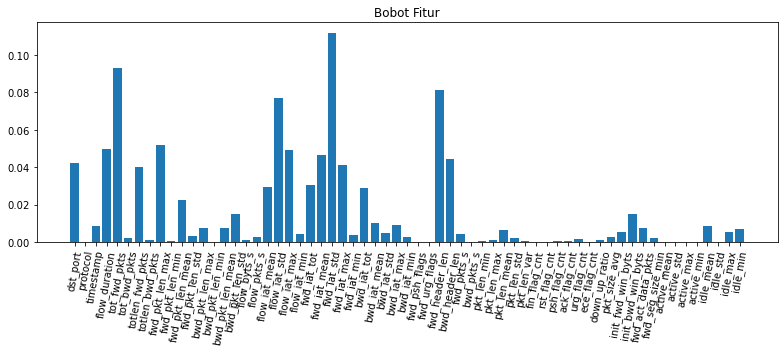

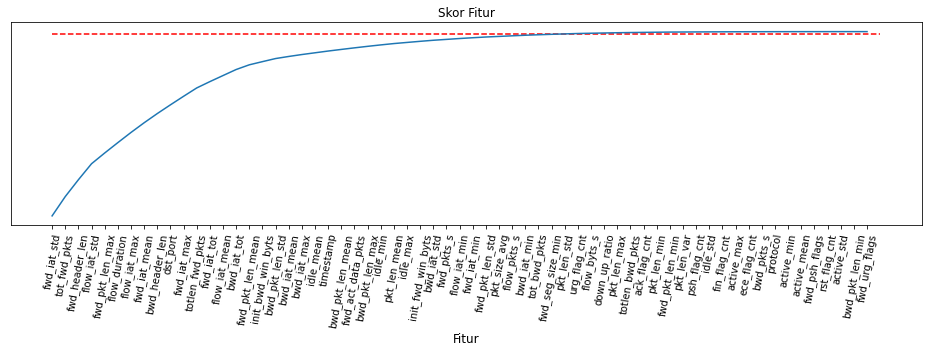

In [11]:
# Seleksi fitur dengan 'random forest' #
# ==================================== #

m_sf = time.time()

# ambang batas persentase skor
persentase_skor = 99

# vektor target
vektor_target = y_train['label_binary']

# jumlah 'trees'
jumlah_trees = 100

# fitur terpilih
klf = RandomForestClassifier(n_estimators=jumlah_trees, random_state=42, n_jobs=-1)
fit = klf.fit(X_train_norm, vektor_target)
fitur_dihapus, fitur_terpilih = fitur_terbaik (fit, persentase_skor, X_train_norm, 'rf')

s_sf = time.time()
print ('')
print ("Lama waktu seleksi fitur 'random forest' : ", s_sf - m_sf)

In [12]:
# hapus fitur dengan nilai bobot terendah
X_train_layer_1 = X_train_norm.drop(fitur_dihapus, axis=1)
X_test_layer_1 = X_test_norm.drop(fitur_dihapus, axis=1)

# 'save' fitur yang dihapus
fitur_dihapus = pd.DataFrame(fitur_dihapus)
fitur_dihapus.to_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Save model\\Rasio 1_1\\f1_skor\\fitur_dihapus_layer_1.txt", index=False)

### 2.2. Seleksi fitur layer 2

Fitur yang dihapus
['urg_flag_cnt', 'flow_byts_s', 'down_up_ratio', 'pkt_len_max', 'totlen_bwd_pkts', 'ack_flag_cnt', 'pkt_len_min', 'fwd_pkt_len_min', 'pkt_len_var', 'psh_flag_cnt', 'idle_std', 'fin_flag_cnt', 'active_max', 'ece_flag_cnt', 'bwd_pkts_s', 'protocol', 'active_min', 'active_mean', 'fwd_psh_flags', 'rst_flag_cnt', 'active_std', 'bwd_pkt_len_min', 'fwd_urg_flags']


Fitur dengan skor terbaik
                Fitur  Persentase Informasi
0         fwd_iat_std             11.180273
1        tot_fwd_pkts              9.305623
2      fwd_header_len              8.117754
3        flow_iat_std              7.714142
4     fwd_pkt_len_max              5.172738
5       flow_duration              4.998515
6        flow_iat_max              4.897240
7        fwd_iat_mean              4.673972
8      bwd_header_len              4.428695
9            dst_port              4.214506
10        fwd_iat_max              4.110468
11    totlen_fwd_pkts              4.029659
12        fwd_iat_tot

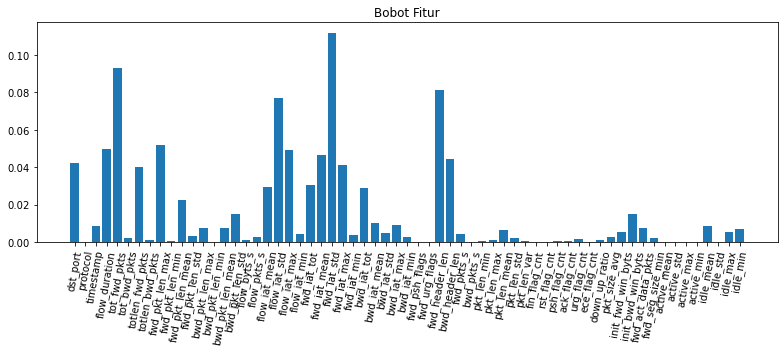

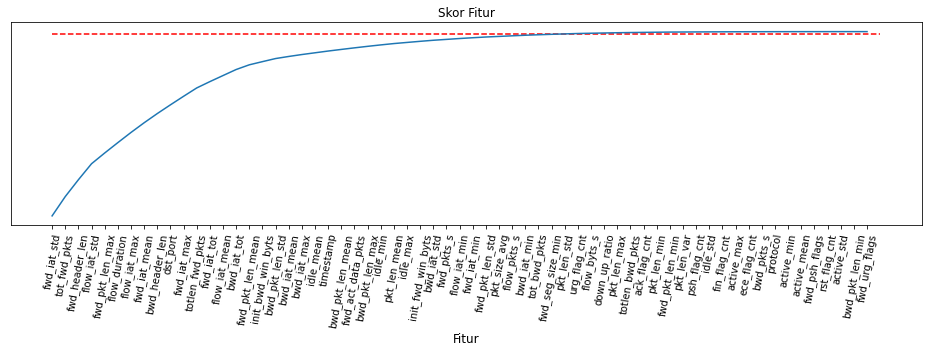

In [13]:
# Seleksi fitur dengan 'random forest' #
# ==================================== #

m_sf = time.time()

# ambang batas persentase skor
persentase_skor = 99

# vektor target
vektor_target = y_train['label_binary']

# jumlah 'trees'
jumlah_trees = 100

# fitur terpilih
klf = RandomForestClassifier(n_estimators=jumlah_trees, random_state=42, n_jobs=-1)
fit = klf.fit(X_train_norm, vektor_target)
fitur_dihapus, fitur_terpilih = fitur_terbaik (fit, persentase_skor, X_train_norm, 'rf')

s_sf = time.time()
print ('')
print ("Lama waktu seleksi fitur 'random forest' : ", s_sf - m_sf)

In [14]:
# hapus fitur dengan nilai bobot terendah
X_train_layer_2 = X_train_norm.drop(fitur_dihapus, axis=1)
X_test_layer_2 = X_test_norm.drop(fitur_dihapus, axis=1)

# 'save' fitur yang dihapus
fitur_dihapus = pd.DataFrame(fitur_dihapus)
fitur_dihapus.to_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Save model\\Rasio 1_1\\f1_skor\\fitur_dihapus_layer_2.txt", index=False)

### 2.3. seleksi fitur layer 3

Fitur yang dihapus
['idle_max', 'idle_mean', 'psh_flag_cnt', 'bwd_iat_mean', 'pkt_len_std', 'urg_flag_cnt', 'bwd_iat_std', 'rst_flag_cnt', 'ece_flag_cnt', 'idle_min', 'flow_byts_s', 'bwd_iat_min', 'bwd_pkt_len_min', 'pkt_len_min', 'fwd_pkt_len_min', 'idle_std', 'active_max', 'protocol', 'active_min', 'fin_flag_cnt', 'fwd_psh_flags', 'active_std', 'active_mean', 'fwd_urg_flags']


Fitur dengan skor terbaik
                Fitur  Persentase Informasi
0           timestamp             10.560959
1   init_fwd_win_byts              8.300108
2            dst_port              5.944268
3      fwd_header_len              5.547529
4        tot_fwd_pkts              5.066573
5    fwd_seg_size_min              4.625303
6         fwd_iat_std              4.451333
7        flow_iat_std              4.185843
8       flow_duration              3.814342
9       flow_iat_mean              3.767701
10       flow_iat_max              3.553180
11     bwd_header_len              3.502978
12    fwd_pkt_len_m

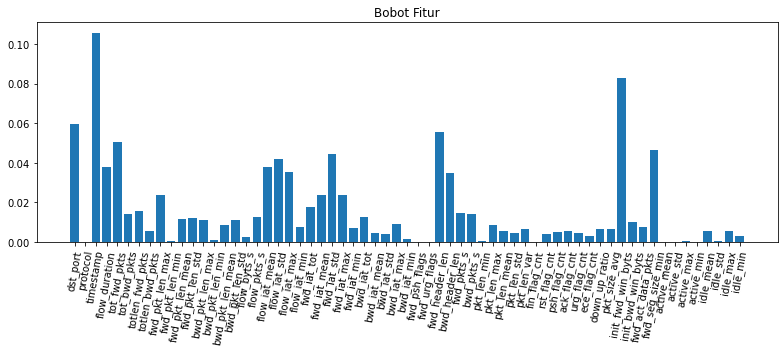

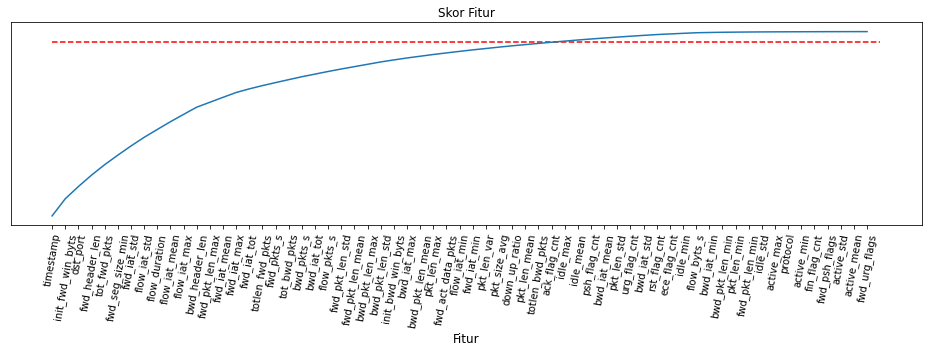

In [15]:
# Seleksi fitur dengan 'random forest' #
# ==================================== #

m_sf = time.time()

# ambang batas persentase skor
persentase_skor = 95

# vektor target
vektor_target = y_train['label']

# jumlah 'trees'
jumlah_trees = 100

# fitur terpilih
klf = RandomForestClassifier(n_estimators=jumlah_trees, random_state=42, n_jobs=-1)
fit = klf.fit(X_train_norm, vektor_target)
fitur_dihapus, fitur_terpilih = fitur_terbaik (fit, persentase_skor, X_train_norm, 'rf')

s_sf = time.time()
print ('')
print ("Lama waktu seleksi fitur 'random forest' : ", s_sf - m_sf)

In [16]:
# hapus fitur dengan nilai bobot terendah
X_train_layer_3 = X_train_norm.drop(fitur_dihapus, axis=1)
X_test_layer_3  = X_test_norm.drop(fitur_dihapus, axis=1)

# 'save' fitur yang dihapus
fitur_dihapus = pd.DataFrame(fitur_dihapus)
fitur_dihapus.to_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Save model\\Rasio 1_1\\f1_skor\\fitur_dihapus_layer_3.txt", index=False)

# =================

## 3. Pembangunan model

## 3.1. Layer 1 - LSTM

In [17]:
# lapisan 1 - LSTM #
# ================ #

# konversi data latih dan uji ke array
X_train_1 = X_train_layer_1.to_numpy()
X_test_1 = X_test_layer_1.to_numpy()

# konversi variabel output (y) ke array
y_train_1 = y_train['label_binary_code'].to_numpy()
y_test_1 = y_test['label_binary_code'].to_numpy()

# 'reshape' ke bentuk 3 dimensi
X_train_1 = np.reshape(X_train_1, (X_train_1.shape[0], 1, X_train_1.shape[1]))
X_test_1 = np.reshape(X_test_1, (X_test_1.shape[0], 1, X_test_1.shape[1]))

In [18]:
# penentuan 'seed' untuk angka acak yang dihasilkan 'numpy', 'tensorflow', 'python'
np.random.seed(42)
tf.random.set_seed(42)
rn.seed(42)

In [19]:
# nilai hyperparameter lapisan 1
unit          = 64
learning_rate = 0.05
epochs        = 40
dropout       = 0.1
batch_size    = 512

# model LSTM
model = Sequential()
model.add(LSTM(unit, input_shape=(1, X_train_1.shape[2])))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))
opt = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

In [20]:
# pelatihan model lapisan 1
m_latih_1 = time.time()
model.fit(X_train_1, y_train_1, batch_size = batch_size, epochs = epochs, shuffle=False) 
s_latih_1 = time.time()

# klasifikasi biner kelas lapisan 1
m_pred_1 = time.time()
y_pred_1 = model.predict(X_test_1)
y_pred_1 = ((y_pred_1 > 0.5)+0).ravel()
s_pred_1 = time.time()
print ('waktu latih model lapisan 1 - LSTM       : ', s_latih_1 - m_latih_1)
print ('waktu klasifikasi model lapisan 1 - LSTM : ', s_pred_1 - m_pred_1)

Epoch 1/40
8577/8577 [==============================] - 31s 3ms/step - loss: 0.0167 - acc: 0.9947
Epoch 2/40
8577/8577 [==============================] - 29s 3ms/step - loss: 0.0115 - acc: 0.9962
Epoch 3/40
8577/8577 [==============================] - 30s 3ms/step - loss: 0.0109 - acc: 0.9963
Epoch 4/40
8577/8577 [==============================] - 30s 3ms/step - loss: 0.0106 - acc: 0.9964
Epoch 5/40
8577/8577 [==============================] - 30s 3ms/step - loss: 0.0104 - acc: 0.9964
Epoch 6/40
8577/8577 [==============================] - 30s 3ms/step - loss: 0.0102 - acc: 0.9964
Epoch 7/40
8577/8577 [==============================] - 30s 3ms/step - loss: 0.0101 - acc: 0.9965
Epoch 8/40
8577/8577 [==============================] - 30s 3ms/step - loss: 0.0100 - acc: 0.9965
Epoch 9/40
8577/8577 [==============================] - 30s 3ms/step - loss: 0.0099 - acc: 0.9965
Epoch 10/40
8577/8577 [==============================] - 31s 4ms/step - loss: 0.0099 - acc: 0.9965
Epoch 11/40
8577/85

In [85]:
# 'save' model
model.save("G:\\Universitas Indonesia\\Rancangan Paper\\Save model\\Rasio 1_1\\f1_skor\\model_lstm_layer_1.joblib")

INFO:tensorflow:Assets written to: G:\Universitas Indonesia\Rancangan Paper\Save model\Rasio 1_1\f1_skor\model_lstm_layer_1.joblib\assets


INFO:tensorflow:Assets written to: G:\Universitas Indonesia\Rancangan Paper\Save model\Rasio 1_1\f1_skor\model_lstm_layer_1.joblib\assets


In [95]:
# 'save' y prediksi layer 1
#y_pred_1 = pd.Series(y_pred_1)
#y_pred_1.to_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Save model\\Rasio 1_1\\f1_skor\\y_pred_1.txt", index=False)

In [ ]:
# 'load' model
#model = keras.models.load_model("G:\\Universitas Indonesia\\Rancangan Paper\\Save model\\Rasio 1_1\\f1_skor\\model_lstm_layer_1.joblib")

In [39]:
# klasifikasi biner kelas lapisan 1
m_pred_1 = time.time()
y_pred_1 = model.predict(X_test_1)
y_pred_1 = ((y_pred_1 > 0.5)+0).ravel()
s_pred_1 = time.time()
print ('waktu latih model lapisan 1 - LSTM       : ', s_latih_1 - m_latih_1)
print ('waktu klasifikasi model lapisan 1 - LSTM : ', s_pred_1 - m_pred_1)

waktu latih model lapisan 1 - LSTM       :  821.7761535644531
waktu klasifikasi model lapisan 1 - LSTM :  23.022979736328125


In [21]:
# Hasil klasifikasi biner kelas lapisan 1 #
# ======================================= #

# hasil klasifikasi biner kelas lapisan 1
y_pred_1 = pd.Series(y_pred_1)
print ('Hasil klasifikasi biner kelas lapisan 1')
print (y_pred_1.value_counts())

Hasil klasifikasi biner kelas lapisan 1
0    551940
1    545820
dtype: int64



Accuracy, Precision, Recall dan F1-score :
Accuracy  : 0.9968718116892581
Precision : 0.9968872551951413
Recall    : 0.9968718116892581
F1-score  : 0.9968717873826527

metrik evaluasi :
              precision    recall  f1-score   support

           0   0.994117  0.999659  0.996881    548880
           1   0.999657  0.994084  0.996863    548880

    accuracy                       0.996872   1097760
   macro avg   0.996887  0.996872  0.996872   1097760
weighted avg   0.996887  0.996872  0.996872   1097760


matriks "confusion" :


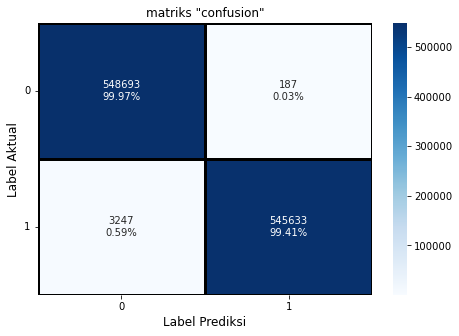

misklasifikasi kelas target:
   misklasifikasi   total  persentase_misklasifikasi
1            3247  548880                   0.591568
0             187  548880                   0.034069


In [22]:
# Evaluasi model lapisan 1 #
# ======================== #

# metrik pengukuran lapisan 1
metrik (None, 1, y_aktual_binercode, y_pred_1)

# misklasifikasi lapisan 1
misklasifikasi(y_aktual_binercode, y_pred_1)

## 3.2. Layer 2 - Random Forest

In [23]:
# Data normal dan data serangan hasil klasifikasi lapisan 1 #
# ========================================================= #

# konversi hasil prediksi '0' dan '1' menjadi 'benign' dan 'attack' 
y_pred_1 = pd.DataFrame(np.where(y_pred_1 == 0, 'benign','attack'),columns=['label_prediksi'])

# gabung data uji dan label prediksi dari lapisan 1
data_1 = pd.concat([X_test_layer_2, y_pred_1], axis=1)

# bagi data menjadi subset data normal dan subset data serangan
data_normal_1 = data_1.loc[data_1['label_prediksi'].isin(['benign'])]
data_serangan_1 = data_1.loc[data_1['label_prediksi'].isin(['attack'])]

# bagi masing - masing subset data menjadi variabel input (X) dan variabel output/label (y)
X_normal_1, y_normal_1 = variabel_input_output(data_normal_1, 1, 'label_prediksi')
X_serangan_1, y_serangan_1 = variabel_input_output(data_serangan_1, 1, 'label_prediksi')

In [24]:
data_1['label_prediksi'].value_counts()

benign    551940
attack    545820
Name: label_prediksi, dtype: int64

In [25]:
# Lapisan 2 - Random Forest #
# =========================== #

# hyperparameter lapisan 2
n_estimators      = 30
min_samples_split = 5 
min_samples_leaf  = 9
max_features      = 18
max_depth         = 15

# model random forest
klf_layer_2 = RandomForestClassifier(n_estimators=n_estimators,min_samples_split=min_samples_split,
                                     min_samples_leaf=min_samples_leaf,max_features=max_features,
                                     max_depth=max_depth,random_state=42,n_jobs=-1)

# pelatihan model lapisan 2
m_latih_2 = time.time()
klf_layer_2.fit(X_train_layer_2, y_train['label_binary'])
s_latih_2 = time.time()

# klasifikasi biner kelas lapisan 2
m_pred_2 = time.time()
y_pred_2 = klf_layer_2.predict(X_normal_1)
s_pred_2 = time.time()

print('Waktu latih lapisan 2 - random forest        :', s_latih_2 - m_latih_2)
print('Waktu klasifikasi lapisan 2 - random forest  :', s_pred_2 - m_pred_2)

Waktu latih lapisan 2 - random forest        : 368.8118095397949
Waktu klasifikasi lapisan 2 - random forest  : 0.4074568748474121


In [101]:
# 'save' model
joblib.dump(klf_layer_2, "G:\\Universitas Indonesia\\Rancangan Paper\\Save model\\Rasio 1_1\\f1_skor\\model_rf_layer_2.joblib")

['G:\\Universitas Indonesia\\Rancangan Paper\\Save model\\Rasio 1_1\\f1_skor\\model_rf_layer_2.joblib']

In [ ]:
# 'load' model
klf_layer_2 = joblib.load("G:\\Universitas Indonesia\\Rancangan Paper\\Save model\\Rasio 1_1\\f1_skor\\model_rf_layer_2.joblib")

In [26]:
# Hasil klasifikasi biner kelas lapisan 2 #
# ======================================= #

# hasil klasifikasi biner kelas lapisan 2
y_pred_2 = pd.Series(y_pred_2)
print ('Hasil klasifikasi biner kelas lapisan 2')
y_pred_2.value_counts()

Hasil klasifikasi biner kelas lapisan 2


benign    549456
attack      2484
dtype: int64

In [27]:
# Hasil klasifikasi biner kelas lapisan 1 dan 2 #
# ============================================= #

# gabungan hasil klasifikasi biner kelas lapisan 1 dan 2
y_pred_2.index = X_normal_1.index
y_pred_1_2 = pd.concat([y_pred_2, y_serangan_1], axis=0).sort_index()
print ('Hasil klasifikasi biner kelas lapisan 1 dan 2')
y_pred_1_2.value_counts()

Hasil klasifikasi biner kelas lapisan 1 dan 2


benign    549456
attack    548304
dtype: int64

In [103]:
# 'save' y prediksi layer 2
#y_pred_2.to_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Save model\\Rasio 1_1\\f1_skor\\y_pred_2.txt", index=False)


Accuracy, Precision, Recall dan F1-score :
Accuracy  : 0.9980979449059904
Precision : 0.9980984934423025
Recall    : 0.9980979449059904
F1-score  : 0.9980979443823257

metrik evaluasi :
              precision    recall  f1-score   support

      attack   0.998621  0.997573  0.998097    548880
      benign   0.997576  0.998623  0.998099    548880

    accuracy                       0.998098   1097760
   macro avg   0.998098  0.998098  0.998098   1097760
weighted avg   0.998098  0.998098  0.998098   1097760


matriks "confusion" :


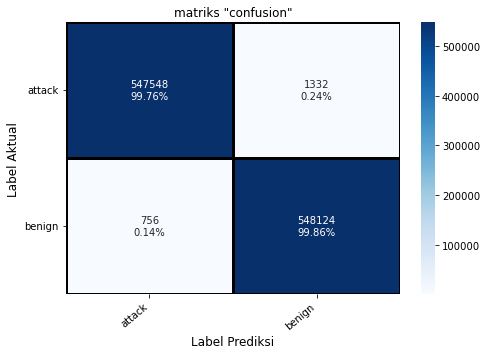

misklasifikasi kelas target:
        misklasifikasi   total  persentase_misklasifikasi
attack            1332  548880                   0.242676
benign             756  548880                   0.137735


In [28]:
# Evaluasi model hibrid biner kelas lapisan 1 dan 2 #
# ================================================= #

# pengukuran model hibrid lapisan 1 dan 2
metrik(klf_layer_2, 1, y_aktual_biner, y_pred_1_2)

# misklasifikasi model hibrid lapisan 1 dan 2
misklasifikasi(y_aktual_biner, y_pred_1_2)

## 3.3. Layer 3 - Random Forest ( Multi kelas )

In [29]:
# Data normal dan data serangan gabungan hasil klasifikasi lapisan 1 dan 2 #
# ======================================================================== #

# gabung data uji dan hasil prediksi dari lapisan 1 dan 2
y_pred_1_2 = pd.DataFrame(y_pred_1_2,columns=['label_prediksi'])
data_1_2 = pd.concat([X_test_layer_3, y_pred_1_2], axis=1)

# bagi data menjadi subset data normal dan subset data serangan
data_normal_1_2 = data_1_2.loc[data_1_2['label_prediksi'].isin(['benign'])]
data_serangan_1_2 = data_1_2.loc[data_1_2['label_prediksi'].isin(['attack'])]

# bagi masing - masing subset data menjadi variabel input (X) dan variabel output/label (y)
X_normal_1_2, y_normal_1_2 = variabel_input_output(data_normal_1_2, 1, 'label_prediksi')
X_serangan_1_2, y_serangan_1_2 = variabel_input_output(data_serangan_1_2, 1, 'label_prediksi')

In [30]:
data_1_2['label_prediksi'].value_counts()

benign    549456
attack    548304
Name: label_prediksi, dtype: int64

In [31]:
# lapisan 3 - Random Forest (multikelas) #
# ====================================== #

# hyperparameter lapisan 3
n_estimators      = 10
min_samples_split = 20
min_samples_leaf  = 2
max_features      = 12
max_depth         = None
 
klf_layer_3 = RandomForestClassifier(n_estimators=n_estimators,min_samples_split=min_samples_split,
                                     min_samples_leaf=min_samples_leaf,max_features=max_features,
                                     max_depth=max_depth,random_state=42,n_jobs=-1)

# pelatihan model lapisan 3
m_latih_3 = time.time()
klf_layer_3.fit(X_train_layer_3, y_train['label'])
s_latih_3 = time.time()

# klasifikasi multi kelas lapisan 3
m_pred_3 = time.time()
y_pred_3 = klf_layer_3.predict(X_serangan_1_2)
s_pred_3 = time.time()

print('waktu latih lapisan 3 - random forest        :', s_latih_3 - m_latih_3)
print('waktu klasifikasi lapisan 3 - random forest  :', s_pred_3 - m_pred_3)

waktu latih lapisan 3 - random forest        : 112.07750940322876
waktu klasifikasi lapisan 3 - random forest  : 0.42238283157348633


In [38]:
# klasifikasi multi kelas lapisan 3
m_pred_3 = time.time()
y_pred_3 = klf_layer_3.predict(X_serangan_1_2)
s_pred_3 = time.time()

In [107]:
# 'save' model
#joblib.dump(klf_layer_3, "G:\\Universitas Indonesia\\Rancangan Paper\\Save model\\Rasio 1_1\\f1_skor\\model_rf_layer_3.joblib")

['G:\\Universitas Indonesia\\Rancangan Paper\\Save model\\Rasio 1_1\\f1_skor\\model_rf_layer_3.joblib']

In [ ]:
# 'load' model
#klf_layer_3 = joblib.load("G:\\Universitas Indonesia\\Rancangan Paper\\Save model\\Rasio 1_1\\f1_skor\\model_rf_layer_3.joblib")

In [32]:
# hasil klasifikasi multi kelas lapisan 3 #
# ======================================= #

# hasil klasifikasi multi kelas lapisan 3
y_pred_3 = pd.Series(y_pred_3)
print ('Hasil klasifikasi multi kelas lapisan 3')
y_pred_3.value_counts()

Hasil klasifikasi multi kelas lapisan 3


ddos_attack_hoic            137202
ddos_attacks_loic_http      115238
dos_attacks_hulk             92381
bot                          57186
ftp_bruteforce               38671
ssh_bruteforce               37518
infilteration                30689
dos_attacks_slowhttptest     27978
dos_attacks_goldeneye         8302
dos_attacks_slowloris         2198
benign                         425
ddos_attack_loic_udp           346
brute_force__web               114
brute_force__xss                43
sql_injection                   13
dtype: int64

In [33]:
# Hasil klasifikasi multi kelas lapisan 1, 2 dan 3 #
# ================================================ #

# gabungan hasil klasifikasi multi kelas lapisan 1, 2, dan 3
y_pred_3.index = y_serangan_1_2.index
y_pred_1_2_3 = pd.concat([y_normal_1_2, y_pred_3], axis=0).sort_index()
print ('Hasil klasifikasi multi kelas lapisan 1, 2, dan 3')
y_pred_1_2_3.value_counts()

Hasil klasifikasi multi kelas lapisan 1, 2, dan 3


benign                      549881
ddos_attack_hoic            137202
ddos_attacks_loic_http      115238
dos_attacks_hulk             92381
bot                          57186
ftp_bruteforce               38671
ssh_bruteforce               37518
infilteration                30689
dos_attacks_slowhttptest     27978
dos_attacks_goldeneye         8302
dos_attacks_slowloris         2198
ddos_attack_loic_udp           346
brute_force__web               114
brute_force__xss                43
sql_injection                   13
dtype: int64

In [109]:
# 'save' y prediksi layer 3
#y_pred_3.to_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Save model\\Rasio 1_1\\f1_skor\\y_pred_3.txt", index=False)


Accuracy, Precision, Recall dan F1-score :
Accuracy  : 0.9982582713890104
Precision : 0.9909491283706167
Recall    : 0.9680734161977018
F1-score  : 0.9784389679347011

metrik evaluasi :
                          precision    recall  f1-score   support

                  benign   0.997361  0.999180  0.998270    548880
                     bot   1.000000  0.999983  0.999991     57187
        brute_force__web   0.982456  0.949153  0.965517       118
        brute_force__xss   0.976744  0.913043  0.943820        46
        ddos_attack_hoic   1.000000  1.000000  1.000000    137202
    ddos_attack_loic_udp   1.000000  1.000000  1.000000       346
  ddos_attacks_loic_http   1.000000  1.000000  1.000000    115238
   dos_attacks_goldeneye   0.999880  0.999880  0.999880      8302
        dos_attacks_hulk   1.000000  0.999989  0.999995     92382
dos_attacks_slowhttptest   1.000000  1.000000  1.000000     27978
   dos_attacks_slowloris   0.999545  0.999545  0.999545      2198
          ftp_brutef

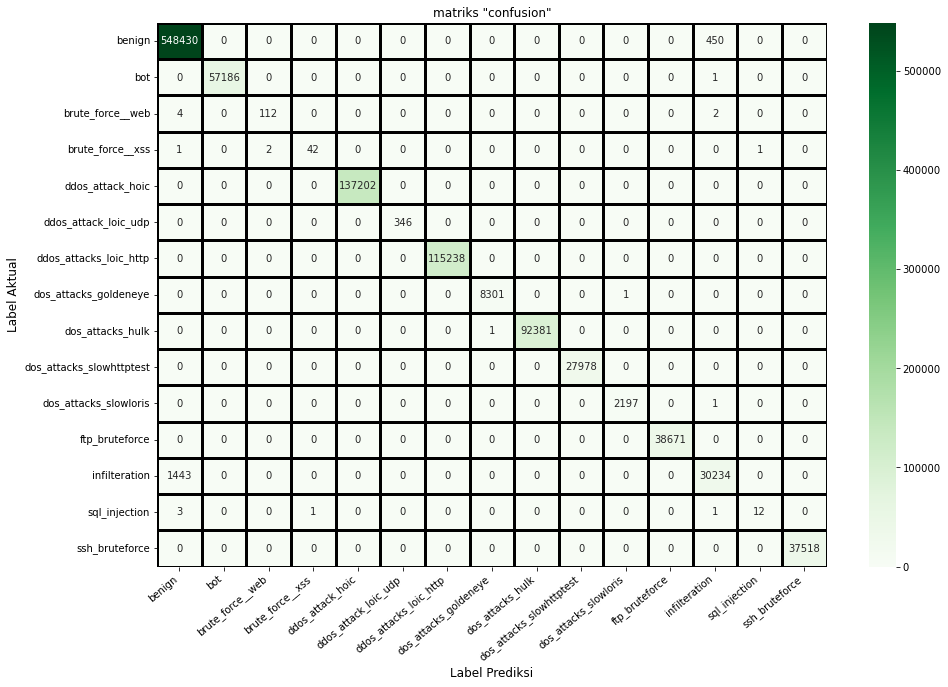

misklasifikasi kelas target:
                          misklasifikasi   total  persentase_misklasifikasi
sql_injection                          5      17                  29.411765
brute_force__xss                       4      46                   8.695652
brute_force__web                       6     118                   5.084746
infilteration                       1443   31677                   4.555356
benign                               450  548880                   0.081985
dos_attacks_slowloris                  1    2198                   0.045496
dos_attacks_goldeneye                  1    8302                   0.012045
bot                                    1   57187                   0.001749
dos_attacks_hulk                       1   92382                   0.001082
ddos_attack_hoic                       0  137202                   0.000000
ddos_attack_loic_udp                   0     346                   0.000000
ddos_attacks_loic_http                 0  115238           

In [34]:
# Evaluasi model hibrid multi kelas lapisan 1, 2, dan 3 #
# ===================================================== #

# pengukuran model hibrid lapisan 1, 2, dan 3 
metrik(klf_layer_3, 2, y_aktual_multi, y_pred_1_2_3)

# misklasifikasi model hibrid lapisan 1, 2, dan 3 
misklasifikasi(y_aktual_multi, y_pred_1_2_3)

In [35]:
# dataset layer 3
y_pred_3 = pd.DataFrame(y_pred_3,columns=['label_prediksi'])
dataset_3 = pd.concat([X_test_layer_3, y_aktual_multi, y_pred_3], axis=1)

## 3.3.2. Layer 3 - Random Forest ( Multi --> Biner )

In [36]:
# Konversi hasil klasifikasi multi kelas menjadi biner kelas #
# ========================================================== #

# gabung data uji dan hasil klasifikasi multikelas dari lapisan 1, 2, dan 3
y_pred_1_2_3 = pd.DataFrame(y_pred_1_2_3,columns=['label_prediksi'])
data_3_biner = pd.concat([X_test_layer_3, y_pred_1_2_3], axis=1)

# konversi hasil klasifikasi 'benign' dan 'multi kelas attacks' menjadi 'benign' dan 'attack'
data_3_biner['label_prediksi'] = np.where(data_3_biner['label_prediksi'] == 'benign', 'benign', 'attack')

# hasil klasifikasi biner kelas untuk evaluasi model hibrid lapisan 1, 2, dan 3
X_prediksi_biner, y_prediksi_biner = variabel_input_output(data_3_biner, 1, 'label_prediksi')

In [116]:
# 'save' y prediksi layer 3
#y_pred_3_biner.to_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Save model\\Rasio 1_1\\f1_skor\\y_pred_3_biner.txt", index=False)


Accuracy, Precision, Recall dan F1-score :
Accuracy  : 0.9982682917941991
Precision : 0.9982699490060781
Recall    : 0.9982682917941992
F1-score  : 0.9982682903543121

metrik evaluasi :
              precision    recall  f1-score   support

      attack   0.999179  0.997356  0.998267    548880
      benign   0.997361  0.999180  0.998270    548880

    accuracy                       0.998268   1097760
   macro avg   0.998270  0.998268  0.998268   1097760
weighted avg   0.998270  0.998268  0.998268   1097760


matriks "confusion" :


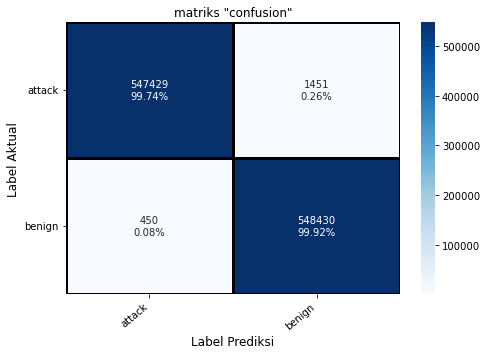

misklasifikasi kelas target:
        misklasifikasi   total  persentase_misklasifikasi
attack            1451  548880                   0.264357
benign             450  548880                   0.081985


In [37]:
# Evaluasi model hibrid biner kelas lapisan 1, 2, dan 3 #
# ===================================================== #

# pengukuran model hibrid lapisan 1, 2, dan 3 
metrik(klf_layer_2, 1, y_aktual_biner, y_prediksi_biner)

# misklasifikasi model hibrid lapisan 1, 2, dan 3 
misklasifikasi(y_aktual_biner, y_prediksi_biner)

## 3.4. Plot Hasil

In [45]:
layer_ke

[1, 2, 3]

In [50]:
akurasi = [0.9966149249380557, 0.9978510785599767, 0.9982354977408541]
presisi = [0.9966280526927781,
 0.9978512425305406,
 0.9982367697204633]
recall = [0.9966149249380556,
 0.9978510785599767,
 0.9982354977408541]
f1_skor =[0.9966149025678288,
 0.9978510783830363,
 0.9982354966146767]


 PLOT AKURASI


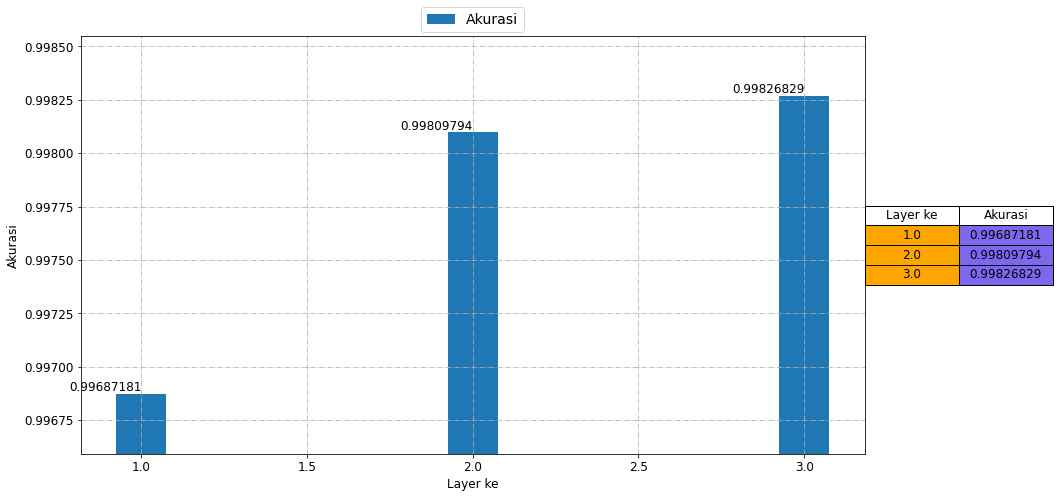


 PLOT PRESISI


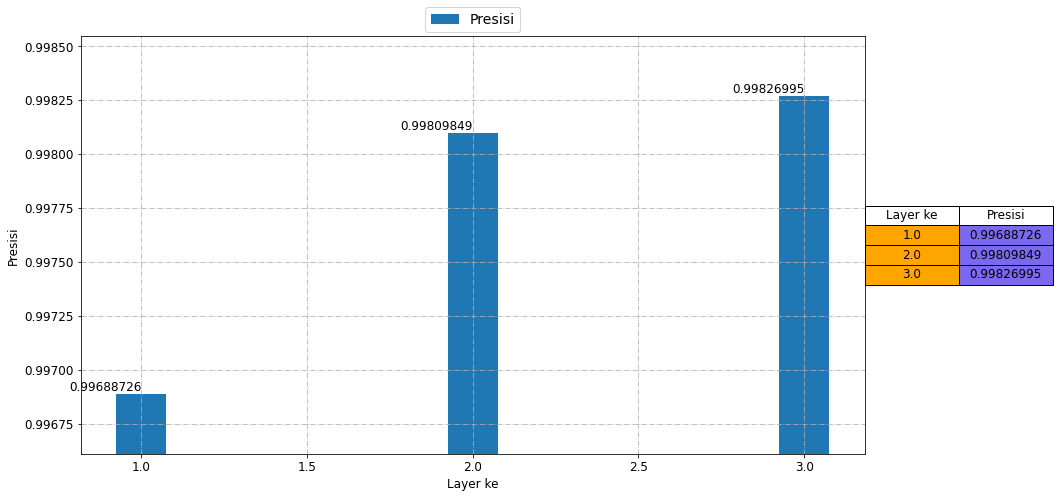


 PLOT RECALL


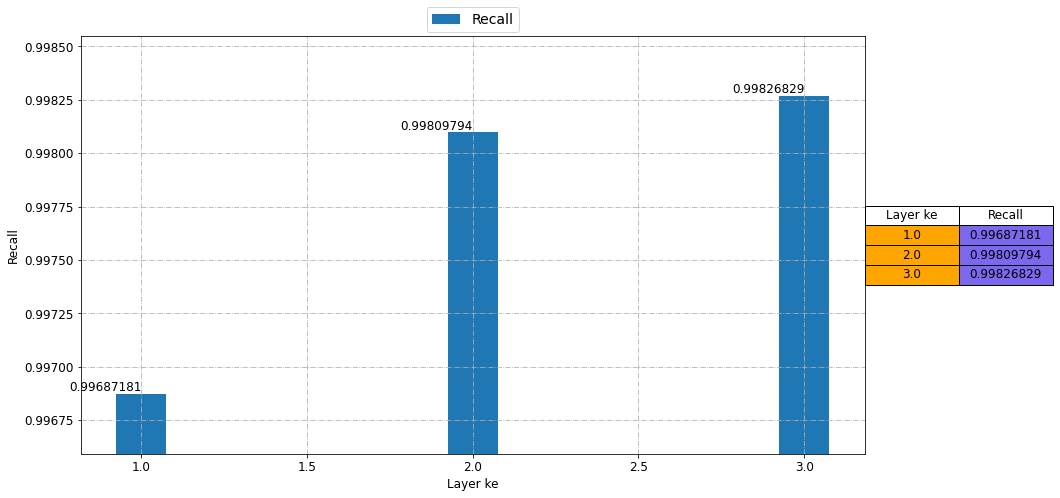


 PLOT F1-SCORE


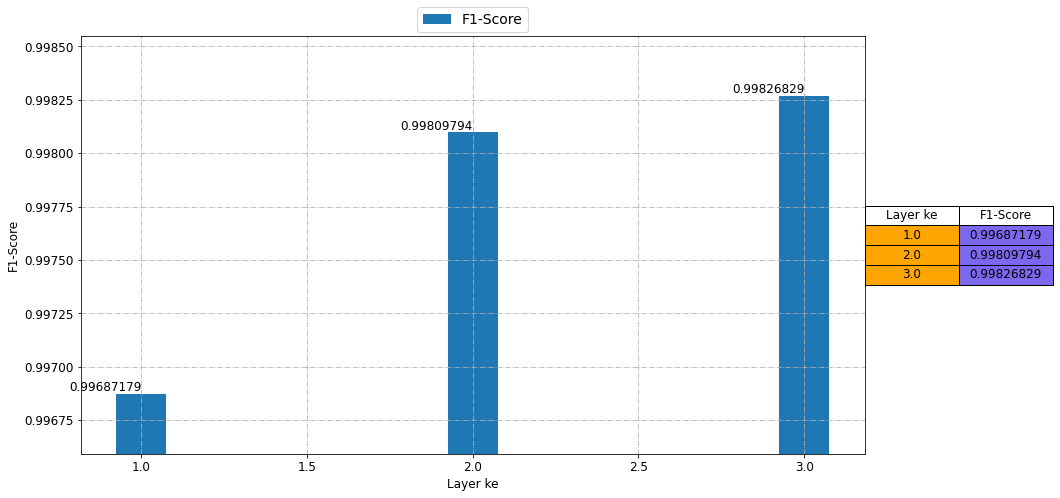

In [38]:
# Plot hasil #
# ========== #

layer_ke = [i+1 for i in range(len(akurasi))]

# Plot Akurasi
plot_klf(akurasi,layer_ke,'Layer ke','Akurasi')

# Plot Presisi
plot_klf(presisi,layer_ke,'Layer ke','Presisi')

# Plot recall
plot_klf(recall,layer_ke,'Layer ke','Recall')

# Plot F1 skor
plot_klf(f1_skor,layer_ke,'Layer ke','F1-Score')

## 3.4. Total Paket yang ditangani model

In [11]:
# total waktu prediksi
waktu_pred = (s_pred_1 - m_pred_1)+(s_pred_2 - m_pred_2)+(s_pred_3 - m_pred_3)

# total flow
total_flow = len(X_test)

# total paket
total_fwd_paket = X_test['tot_fwd_pkts'].sum()
total_bwd_paket = X_test['tot_bwd_pkts'].sum()
total_paket = total_fwd_paket+total_bwd_paket

# total paket yang dapat ditangani oleh model
jumlah_paket_per_detik = total_paket/waktu_pred
flow_paket_per_detik = total_flow/waktu_pred
print ('jumlah paket per detik      :', jumlah_paket_per_detik)
print ('jumlah flow paket per detik :', flow_paket_per_detik)

jumlah paket per detik      : 2757691.437814587
jumlah flow paket per detik : 42798.10939093686
